In [1]:
suppressPackageStartupMessages(library(MASS))
suppressPackageStartupMessages(library(nlme))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(GGally))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(mgcv))
suppressPackageStartupMessages(library(ggrepel))

In [54]:
data_dir = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data"

env_data_file = paste(data_dir, "merged_paired_water_quality_data.txt", sep="/")
habitat_file = paste(data_dir, "Transformed_WQ_Vars_and_Habitats.txt", sep="/")

habitat_srs <- read.delim(habitat_file, row.names=1)
envdata_pre <- read.delim(env_data_file, row.names=1)
colnames(envdata_pre)
addl_cols = c('Station', "qPCR.ct", "WaterColumnPosition", "LinearTime", 'FallPeak', "SpringPeak",
              "cruise_id", 'SampleDate', 'Discharge_Sum.15' , 'Discharge_Susquehanna.15' )
envdata <- cbind.data.frame(habitat_srs, envdata_pre[rownames(habitat_srs), addl_cols])
envdata[which(envdata$qPCR.ct %in% c("", 'TBD')), 'qPCR.ct'] = NA
envdata[,'HABITAT'] <- factor(envdata[,'HABITAT'])
envdata[,'Station'] <- factor(envdata[,'Station'])
envdata[,'WaterColumnPosition'] <- factor(envdata[,'WaterColumnPosition'])
envdata[,'cruise_id'] <- factor(envdata[,'cruise_id'])
print(str(envdata))

[1] "Station"                        "OLD_DATE_TIME"                 
 [3] "OldDepth"                       "qPCR.ct"                       
 [5] "CollectionAgency"               "sequencing_ID"                 
 [7] "TrimCount"                      "TotalDepth"                    
 [9] "PctTotalDepth"                  "WaterColumnPosition"           
[11] "cruise_id"                      "SampleDate"                    
[13] "Depth"                          "PHEO"                          
[15] "TN"                             "TP"                            
[17] "CHLA"                           "DOP"                           
[19] "DON"                            "NH4F"                          
[21] "NO2F"                           "NO3F"                          
[23] "PC"                             "PO4F"                          
[25] "DO"                             "PH"                            
[27] "SALINITY"                       "WTEMP"                         
[29] "LinearTime"                     "DayLength"                     
[31] "FallPeak"                       "SpringPeak"                    
[33] "Discharge_Rappahannock.instant" "Discharge_Rappahannock.15"     
[35] "Discharge_Rappahannock.30"      "Discharge_Rappahannock.60"     
[37] "Discharge_Potomac.instant"      "Discharge_Potomac.15"          
[39] "Discharge_Potomac.30"           "Discharge_Potomac.60"          
[41] "Discharge_Susquehanna.instant"  "Discharge_Susquehanna.15"      
[43] "Discharge_Susquehanna.30"       "Discharge_Susquehanna.60"      
[45] "interpolated_CHLA.instant"      "interpolated_CHLA.15"          
[47] "interpolated_CHLA.30"           "interpolated_CHLA.60"          
[49] "measurement_PAR.instant"        "measurement_PAR.15"            
[51] "measurement_PAR.30"             "measurement_PAR.60"            
[53] "WIND_RATIO_BWI.instant"         "WIND_RATIO_BWI.15"             
[55] "WIND_RATIO_BWI.30"              "WIND_RATIO_BWI.60"             
[57] "PRECIP24HR_BWI.instant"         "PRECIP24HR_BWI.15"             
[59] "PRECIP24HR_BWI.30"              "PRECIP24HR_BWI.60"             
[61] "Discharge_Sum.instant"          "Discharge_Sum.15"              
[63] "Discharge_Sum.30"               "Discharge_Sum.60"              
[65] "Latitude"                       "Longitude"

'data.frame':	236 obs. of  27 variables:
 $ PHEO                    : num  -1.223 -0.125 -0.125 -0.414 -0.125 ...
 $ TN                      : num  -0.889 3.102 1.186 1.044 0.691 ...
 $ TP                      : num  0.165 1.63 0.873 0.102 0.65 ...
 $ CHLA                    : num  -0.968 0.862 -0.348 0.677 0.272 ...
 $ DOP                     : num  0.629 -0.24 -0.442 2.48 -0.509 ...
 $ DON                     : num  1.13 -2.78 -1.3 -1.64 -1.22 ...
 $ NH4F                    : num  -0.2277 -1.0574 -0.0443 0.419 0.6352 ...
 $ NO2F                    : num  -0.266 0.661 0.148 0.212 -0.162 ...
 $ NO3F                    : num  0.786 -1.09 -0.342 -0.353 -0.341 ...
 $ PC                      : num  -0.489 2.065 0.544 0.333 0.438 ...
 $ PO4F                    : num  -0.7433 0.0383 0.124 0.4004 0.2463 ...
 $ DO                      : num  0.1231 0.4676 -0.3698 0.0102 -0.3293 ...
 $ PH                      : num  -1.3745 0.3943 -0.0675 0.22 -0.085 ...
 $ SALINITY                : num  -1.916

In [55]:
station_groups = list('1' = c('CB2.2', 'CB3.1'),
                      '2' = c('CB3.2', 'CB3.3C', 'CB4.1C', 'CB4.2C'),
                      '3' = c('CB4.3C', 'CB4.4'),
                      '4' = c('CB5.1', 'CB5.2'),
                      '5' = c('CB5.4', 'CB5.3', 'CB7.1'),
                      '6' = c('CB6.2', 'CB6.1', 'CB6.3', 'CB7.2'),
                      '7' = c('CB6.4', 'CB7.3', 'CB7.4'))

envdata[,'StatName'] <- NA
for (stg in names(station_groups)){
    envdata[which(envdata[,'Station'] %in% station_groups[[stg]]), 'StatName'] <- stg
}

envdata$StatName <- factor(envdata$StatName)
print(sum(is.na(envdata[,'StatName'])))
table(envdata$StatName)


[1] 0



 1  2  3  4  5  6  7 
26 39 28 12 52 59 20 

In [4]:
library(phyloseq)
library(picante)
#OTU table (shared file)
otu_table_dir = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/otu_tables'
otu_table_file = paste(otu_table_dir, "final_rarefied_table.tsv", sep="/")
OTU = read.delim(otu_table_file, row.names=1)
dim(OTU)
OTU.clean1 = OTU[rownames(envdata), ]
dim(OTU.clean1)
OTU.clean = as.matrix(OTU.clean1[,colSums(OTU.clean1) > 0])
dim(OTU.clean)
#Taxonomy of each OTU
taxa_file = paste(otu_table_dir, "taxa_table_with_OTUs.txt", sep="/")
tax = read.delim(taxa_file, row.names=1)
tax_mat = as.matrix(tax)
dim(tax_mat)
colnames(tax_mat)[1] <- 'Domain'
tax_mat[tax_mat == ""] <- NA
tax.clean = tax_mat[colnames(OTU.clean), ]
dim(tax.clean)
tree_dir = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/phylogenetic_tree'
tree_file = paste(tree_dir, "RAxML_rootedTree.root.query_high_abund.ref.tre", sep="/")
tree_obj = read_tree(tree_file, errorIfNULL=T)
tree.clean = prune_taxa(taxa=colnames(OTU.clean), tree_obj)
OTU.phylo = otu_table(OTU.clean, taxa_are_rows = FALSE)
TAX.phylo = tax_table(tax.clean)
physeq2 = phyloseq(OTU.phylo, TAX.phylo, envdata, tree.clean)
physeq2

Loading required package: ape
Loading required package: vegan
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-5


[1]  362 1561

[1]  236 1561

[1]  236 1432

[1] 56832     7

[1] 1432    7

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1432 taxa and 236 samples ]
tax_table()   Taxonomy Table:    [ 1432 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1432 tips and 1431 internal nodes ]

In [56]:
FaithsPD = pd(OTU.clean, tree_obj, include.root=TRUE)
colnames(FaithsPD) <- c('FaithsPD', 'Observed.ASVs')

enspie_fxn <- function(counts){ 1/(sum((counts/sum(counts))*(counts/sum(counts))))}
ENSpie <- as.data.frame(apply(OTU.clean, MAR=1, FUN=enspie_fxn))
colnames(ENSpie) <- c('ENSpie')

alpha_alt <- estimate_richness(physeq2, split = TRUE, measures = c("Chao1", "ACE", 'InvSimpson'))
alpha_alt = alpha_alt[,c("Chao1", "ACE", 'InvSimpson')]
alpha_alt = cbind.data.frame(alpha_alt, ENSpie, FaithsPD)
all_alpha = cbind.data.frame(envdata, alpha_alt, ENSpie, FaithsPD)
full_data_file = paste(data_dir, "Transformed_WQVars_Hab_and_aDiv.txt", sep="/")
write.table(all_alpha, file=full_data_file, sep="\t")

cor(alpha_alt)
class(all_alpha$ENSpie)

,Chao1,ACE,InvSimpson,ENSpie,FaithsPD,Observed.ASVs
Chao1,1.0000000,0.9936186,0.3963959,0.3963959,0.7715492,0.9644671
ACE,0.9936186,1.0000000,0.3995642,0.3995642,0.7802986,0.9711394
InvSimpson,0.3963959,0.3995642,1.0000000,1.0000000,0.5010777,0.5309983
ENSpie,0.3963959,0.3995642,1.0000000,1.0000000,0.5010777,0.5309983
FaithsPD,0.7715492,0.7802986,0.5010777,0.5010777,1.0000000,0.8337790
Observed.ASVs,0.9644671,0.9711394,0.5309983,0.5309983,0.8337790,1.0000000


[1] "numeric"

In [62]:
predictors_avail = c('PHEO', 'TN', 'TP', 'CHLA', 'DOP', 'DON', 'NH4F', 'NO2F', 'NO3F', 'PC', 'PO4F', 
                     'DO', 'PH', 'SALINITY', 'WTEMP', 'Latitude', 'HABITAT', 'StatName',
                     'WaterColumnPosition', 'LinearTime', 'FallPeak', 'Discharge_Susquehanna.15',
                      'Discharge_Sum.15', 'DayLength')
#sapply(all_alpha, class)
predictors_ = all_alpha[,predictors_avail]
response_1 = all_alpha[,'FaithsPD']
response_2 = all_alpha[,'InvSimpson']
dim(predictors_)
length(response_1)
length(response_2)



[1] 236  23

[1] 236

[1] 236

In [63]:
library(doParallel)
library(caret)

numCores <- 3
registerDoParallel(numCores)

ctrl <- rfeControl(functions = rfFuncs,
                   method = "repeatedcv",
                   repeats = 3,
                   number = 5,
                   verbose = T, 
                   allowParallel=T)

lmProfile <- rfe(x=predictors_, y=response_1,
                 sizes = 1:15,
                 rfeControl = ctrl)

lmProfile$fit
lmProfile$optVariables
lmProfile$bestSubset

lmProfile

stopImplicitCluster()


Call:
 randomForest(x = x, y = y, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 11.83861
                    % Var explained: 76.07

[1] "FallPeak"                 "LinearTime"              
 [3] "PO4F"                     "Discharge_Sum.15"        
 [5] "DO"                       "CHLA"                    
 [7] "TP"                       "WTEMP"                   
 [9] "Discharge_Susquehanna.15" "SALINITY"                
[11] "NO2F"                     "TN"

[1] 12


Recursive feature selection

Outer resampling method: Cross-Validated (5 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables  RMSE Rsquared   MAE RMSESD RsquaredSD  MAESD Selected
         1 4.997   0.5195 3.992 0.3710    0.07576 0.2946         
         2 4.543   0.6019 3.563 0.5190    0.08722 0.4698         
         3 3.914   0.6994 3.044 0.3312    0.06338 0.2128         
         4 3.843   0.7115 2.965 0.3653    0.06642 0.2991         
         5 3.780   0.7197 2.924 0.3769    0.06694 0.3124         
         6 3.677   0.7363 2.832 0.3803    0.06680 0.2838         
         7 3.616   0.7444 2.789 0.4112    0.07036 0.3155         
         8 3.592   0.7466 2.742 0.3990    0.06789 0.2889         
         9 3.497   0.7599 2.683 0.3742    0.06647 0.2867         
        10 3.455   0.7656 2.636 0.4146    0.07086 0.3146         
        11 3.451   0.7652 2.647 0.4058    0.06955 0.3010         
        12 3.430   0.7684 2.621 0.3956    0.06698 0.2964        *


In [64]:
registerDoParallel(numCores)

ctrl <- rfeControl(functions = rfFuncs,
                   method = "repeatedcv",
                   repeats = 3,
                   number = 5,
                   verbose = T, 
                   allowParallel=T)

lmProfile <- rfe(x=predictors_, y=response_2,
                 sizes = 1:15,
                 rfeControl = ctrl)

lmProfile$fit
lmProfile$optVariables
lmProfile$bestSubset

lmProfile

stopImplicitCluster()


Call:
 randomForest(x = x, y = y, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 164.5549
                    % Var explained: 55.89

[1] "SALINITY"                 "FallPeak"                
 [3] "WTEMP"                    "Discharge_Sum.15"        
 [5] "LinearTime"               "PO4F"                    
 [7] "Discharge_Susquehanna.15" "CHLA"                    
 [9] "TP"                       "NO3F"                    
[11] "HABITAT"                  "NO2F"                    
[13] "PH"                       "DO"

[1] 14


Recursive feature selection

Outer resampling method: Cross-Validated (5 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables  RMSE Rsquared   MAE RMSESD RsquaredSD MAESD Selected
         1 16.43   0.3336 13.01  1.980     0.1248 1.688         
         2 14.63   0.4383 11.36  1.747     0.1177 1.425         
         3 14.40   0.4555 11.26  1.975     0.1411 1.704         
         4 13.94   0.4876 10.81  1.636     0.1280 1.470         
         5 14.03   0.4802 10.95  1.676     0.1372 1.555         
         6 13.67   0.5060 10.67  1.645     0.1228 1.485         
         7 13.53   0.5145 10.62  1.462     0.1134 1.319         
         8 13.48   0.5186 10.57  1.410     0.1092 1.306         
         9 13.44   0.5221 10.51  1.438     0.1089 1.295         
        10 13.44   0.5225 10.52  1.348     0.1028 1.259         
        11 13.43   0.5207 10.53  1.417     0.1070 1.274         
        12 13.42   0.5207 10.50  1.453     0.1067 1.258         
        13 13

In [66]:
library(nortest)
ad.test(response_1)
ad.test(response_2)
xform_const = powerTransform(lm(response_1~1))$lambda
response_1.1 = response_1^xform_const
ad.test(response_1.1)
print(xform_const)

pred_resp_f = cbind.data.frame(predictors_, response_1.1)
colnames(pred_resp_f) <- c(colnames(predictors_), 'FaithsPD')

pred_resp_i = cbind.data.frame(predictors_, response_2)
colnames(pred_resp_i) <- c(colnames(predictors_), 'InvSimpson')



	Anderson-Darling normality test

data:  response_1
A = 1.8671, p-value = 8.829e-05



	Anderson-Darling normality test

data:  response_2
A = 0.60395, p-value = 0.1155



	Anderson-Darling normality test

data:  response_1.1
A = 1.1531, p-value = 0.005064


      Y1 
2.143919 


In [67]:
upper_model = lm(InvSimpson ~ Discharge_Susquehanna.15+Discharge_Sum.15+SALINITY+FallPeak+WTEMP+LinearTime+PO4F+CHLA+NO2F+NO3F+TP+HABITAT+TN+DO+PH+PHEO+PC, data=pred_resp_i)
lower_model = lm(InvSimpson ~ 1, data=pred_resp_i)
n = length(resid(lower_model))
fbstep_invsimp = stepAIC(lower_model, scope=formula(upper_model), 
                         scale = 0, direction = 'both', trace=1)
length(colnames(fbstep_invsimp$model))
extractAIC(fbstep_invsimp)
colnames(fbstep_invsimp$model)


Start:  AIC=1399.51
InvSimpson ~ 1

                           Df Sum of Sq   RSS    AIC
+ SALINITY                  1   22993.5 65040 1330.1
+ HABITAT                   2   23101.0 64932 1331.7
+ Discharge_Sum.15          1   12229.1 75804 1366.2
+ FallPeak                  1   12013.1 76020 1366.9
+ Discharge_Susquehanna.15  1   11822.9 76210 1367.5
+ PO4F                      1    7839.1 80194 1379.5
+ TN                        1    5160.4 82873 1387.2
+ NO3F                      1    4982.8 83050 1387.8
+ PC                        1    4788.6 83245 1388.3
+ CHLA                      1    4346.1 83687 1389.6
+ WTEMP                     1    3632.4 84401 1391.6
+ NO2F                      1    2840.4 85193 1393.8
+ DO                        1    2359.2 85674 1395.1
+ TP                        1    2003.8 86029 1396.1
+ PHEO                      1    1789.8 86243 1396.7
+ LinearTime                1    1083.6 86950 1398.6
<none>                                  88033 1399.5
+ PH      


Step:  AIC=1256.41
InvSimpson ~ SALINITY + Discharge_Susquehanna.15 + PHEO + WTEMP + 
    PH + NO2F + TP + HABITAT

                           Df Sum of Sq   RSS    AIC
- PHEO                      1     240.5 44724 1255.7
<none>                                  44483 1256.4
+ DO                        1     354.1 44129 1256.5
+ TN                        1     253.9 44230 1257.1
+ PC                        1     165.6 44318 1257.5
+ NO3F                      1     111.9 44372 1257.8
+ CHLA                      1      77.8 44406 1258.0
- HABITAT                   2    1072.0 45555 1258.0
+ Discharge_Sum.15          1      20.1 44463 1258.3
+ LinearTime                1       3.6 44480 1258.4
+ PO4F                      1       1.7 44482 1258.4
+ FallPeak                  1       0.2 44483 1258.4
- PH                        1    1035.3 45519 1259.8
- TP                        1    1697.1 46181 1263.2
- NO2F                      1    1857.8 46341 1264.1
- WTEMP                     1    58

[1] 9

[1]   10.000 1251.243

[1] "InvSimpson"               "SALINITY"                
[3] "Discharge_Susquehanna.15" "WTEMP"                   
[5] "NO2F"                     "TP"                      
[7] "HABITAT"                  "DO"                      
[9] "TN"

In [70]:
abs(cor(apply(pred_resp_i[,colnames(fbstep_invsimp$model)], 2, as.numeric))) > 0.65

,InvSimpson,SALINITY,Discharge_Susquehanna.15,WTEMP,NO2F,TP,HABITAT,DO,TN
InvSimpson,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
SALINITY,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
Discharge_Susquehanna.15,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE
WTEMP,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE
NO2F,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE
TP,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE
HABITAT,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE
DO,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE
TN,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE


In [81]:
eM1 <- lm(InvSimpson~SALINITY + HABITAT + Discharge_Sum.15, data=pred_resp_i)
eM2 <- lm(InvSimpson~SALINITY + TP + NO2F + Discharge_Sum.15, data=pred_resp_i)
eM3 <- lm(InvSimpson~SALINITY + DO + TP + NO2F + Discharge_Sum.15, data=pred_resp_i)
eM4 <- lm(InvSimpson~SALINITY + DO + NO2F + Discharge_Sum.15, data=pred_resp_i)
anova(eM1, eM2, eM3, eM4)
AIC(eM1, eM2, eM3, eM4)
summary(eM1)
drop1(eM1, test="F")


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
231,53961.38,NA,NA,NA,NA
231,54774.68,0,-813.2942,NA,NA
230,51771.29,1,3003.3890,13.342906,0.0003212588
231,52662.87,-1,-891.5808,3.960952,0.0477513460


,df,AIC
,<dbl>,<dbl>
eM1,6,1963.736
eM2,6,1967.267
eM3,7,1955.958
eM4,6,1957.988



Call:
lm(formula = InvSimpson ~ SALINITY + HABITAT + Discharge_Sum.15, 
    data = pred_resp_i)

Residuals:
    Min      1Q  Median      3Q     Max 
-42.914  -9.718   0.181  10.014  42.722 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       5.590e+01  1.870e+00  29.884  < 2e-16 ***
SALINITY          6.643e+00  1.231e+00   5.395 1.70e-07 ***
HABITAT2          9.425e+00  3.058e+00   3.082  0.00231 ** 
HABITAT3         -2.284e+00  2.522e+00  -0.905  0.36624    
Discharge_Sum.15 -6.804e-06  1.661e-06  -4.095 5.84e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.28 on 231 degrees of freedom
Multiple R-squared:  0.387,	Adjusted R-squared:  0.3764 
F-statistic: 36.46 on 4 and 231 DF,  p-value: < 2.2e-16


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,53961.38,1291.997,NA,NA
SALINITY,1,6798.388,60759.77,1318.001,29.10280,1.696235e-07
HABITAT,2,3175.181,57136.56,1301.491,6.79622,1.355233e-03
Discharge_Sum.15,1,3917.029,57878.41,1306.535,16.76817,5.843471e-05


In [146]:
options(repr.plot.width=4, repr.plot.height=3)

vf3 <- varPower(form= ~ Latitude)
vf3 <- varIdent(form= ~ StatName)

evM5 <- gls(InvSimpson~ SALINITY + Discharge_Sum.15 + HABITAT, data=pred_resp_i, weights=vf3)
postResample(pred = predict(evM5), obs = pred_resp_i$InvSimpson)

envM2 <- gam(InvSimpson ~ s(SALINITY, bs = "cs")  + s(Discharge_Sum.15, bs = "cs")
             + HABITAT, data=pred_resp_i)
postResample(pred = predict(envM2), obs = pred_resp_i$InvSimpson)

envM3 <- gam(InvSimpson ~ s(SALINITY, bs = "cs")  + s(Discharge_Sum.15, bs = "cs") + 
                          s(NO2F, bs = "cs") + s(DO, bs = "cs"), data=pred_resp_i)
postResample(pred = predict(envM3), obs = pred_resp_i$InvSimpson)

envM1 <- gam(InvSimpson ~ s(SALINITY, bs = "cs")  + s(Discharge_Sum.15, bs = "cs") + 
                      s(TP, bs = "cs") + s(DO, bs = "cs"), data=pred_resp_i)
postResample(pred = predict(envM1), obs = pred_resp_i$InvSimpson)

envM4 <- gamm(InvSimpson ~ s(SALINITY, bs = "cs") + s(Discharge_Sum.15, bs = "cs")
              + HABITAT, weights=vf3, data=pred_resp_i)
postResample(pred = predict(envM4$gam), obs = pred_resp_i$InvSimpson)

envM5 <- gamm(InvSimpson ~ s(SALINITY, bs = "cs")  + s(Discharge_Sum.15, bs = "cs") + 
                           s(NO2F, bs = "cs") + s(DO, bs = "cs"), weights=vf3, data=pred_resp_i)
postResample(pred = predict(envM5$gam), obs = pred_resp_i$InvSimpson)


#AIC(envM4$lme)
#plot(envM3$gam)
summary(envM2)
anova(envM2)

RMSE   Rsquared        MAE 
15.1211749  0.3870334 11.9479868

RMSE   Rsquared        MAE 
13.1772180  0.5346924 10.1625130

RMSE   Rsquared        MAE 
13.1721162  0.5351496 10.1553046

RMSE   Rsquared        MAE 
13.2151794  0.5323202 10.2291434

RMSE   Rsquared        MAE 
14.1357147  0.4649262 11.0001877

RMSE   Rsquared        MAE 
13.9924609  0.4760135 10.8779015


Family: gaussian 
Link function: identity 

Formula:
InvSimpson ~ s(SALINITY, bs = "cs") + s(Discharge_Sum.15, bs = "cs") + 
    HABITAT

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   52.828      1.591  33.194   <2e-16 ***
HABITAT2       2.996      3.246   0.923    0.357    
HABITAT3      -2.660      2.500  -1.064    0.289    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                      edf Ref.df     F  p-value    
s(SALINITY)         6.570      9 7.080 4.89e-11 ***
s(Discharge_Sum.15) 8.576      9 4.938 2.14e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.498   Deviance explained = 53.5%
GCV = 203.77  Scale est. = 188.1     n = 236


Family: gaussian 
Link function: identity 

Formula:
InvSimpson ~ s(SALINITY, bs = "cs") + s(Discharge_Sum.15, bs = "cs") + 
    HABITAT

Parametric Terms:
        df     F p-value
HABITAT  2 1.393   0.251

Approximate significance of smooth terms:
                      edf Ref.df     F  p-value
s(SALINITY)         6.570  9.000 7.080 4.89e-11
s(Discharge_Sum.15) 8.576  9.000 4.938 2.14e-06

(Intercept)              HABITAT2              HABITAT3 
           52.5518433             3.0272660            -2.2843195 
        s(SALINITY).1         s(SALINITY).2         s(SALINITY).3 
            8.9503645            -4.4413282             2.8416680 
        s(SALINITY).4         s(SALINITY).5         s(SALINITY).6 
            3.8909584             7.8098288             7.3617080 
        s(SALINITY).7         s(SALINITY).8         s(SALINITY).9 
           10.5119211            31.4816989            13.9387515 
s(Discharge_Sum.15).1 s(Discharge_Sum.15).2 s(Discharge_Sum.15).3 
           -0.8750571            -1.4793857            -8.2131420 
s(Discharge_Sum.15).4 s(Discharge_Sum.15).5 s(Discharge_Sum.15).6 
           -5.7398393             3.0648753            -4.4520558 
s(Discharge_Sum.15).7 s(Discharge_Sum.15).8 s(Discharge_Sum.15).9 
           -5.7088534            -8.1876941           -15.1990158

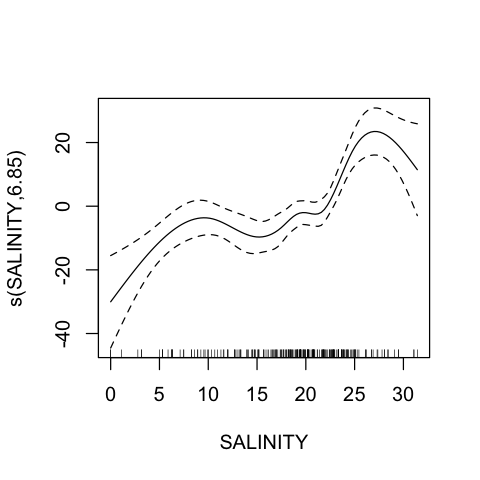

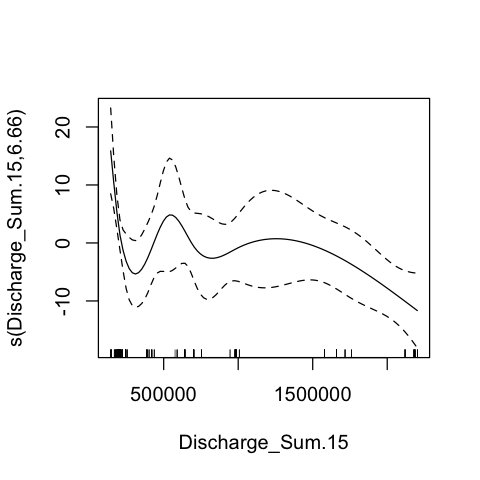

In [140]:
selected_predictors1 = c('SALINITY', 'Discharge_Sum.15', 'cruise_id')
selected_predictors2 = c('HABITAT', 'StatName')
selected_response = c('InvSimpson')
obs_df = cbind.data.frame(envdata_pre[,selected_predictors1], envdata[,selected_predictors2], 
                          all_alpha[,selected_response])
colnames(obs_df) = c(selected_predictors1, selected_predictors2, selected_response)

envM2 <- gam(InvSimpson ~ s(SALINITY, bs = "cs")  + s(Discharge_Sum.15, bs = "cs")
             + HABITAT, data=obs_df)
options(repr.plot.width=4, repr.plot.height=4)
coef(envM2)
plot.gam(envM2, scale=0)



	Shapiro-Wilk normality test

data:  resid(envM2)
W = 0.99336, p-value = 0.3775


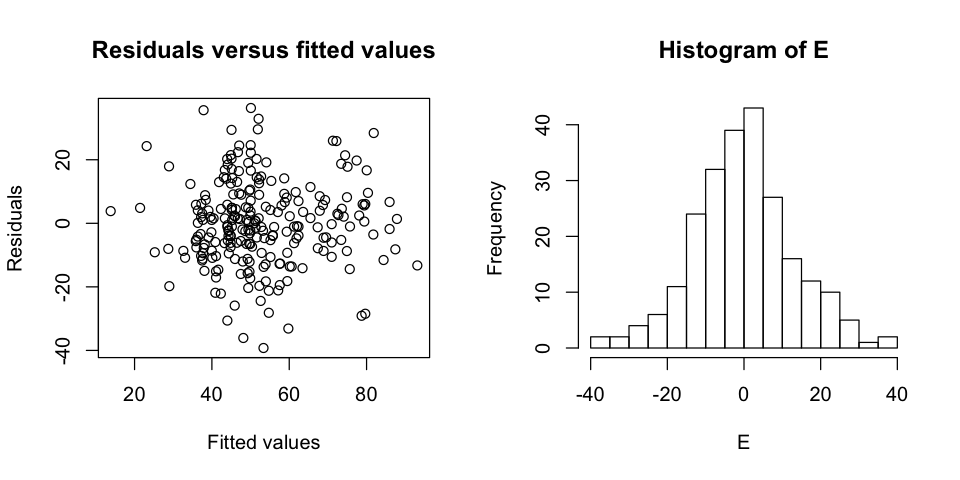

In [94]:
options(repr.plot.width=8, repr.plot.height=4)
shapiro.test(resid(envM2))

E <- resid(envM2)
Fit <- fitted(envM2)
op <- par(mfrow = c(1, 2))
plot(x = Fit,y = E, xlab = "Fitted values", ylab = "Residuals", main = "Residuals versus fitted values")
hist(E, nclass = 15)
par(op)

In [ ]:
plot(envM2)

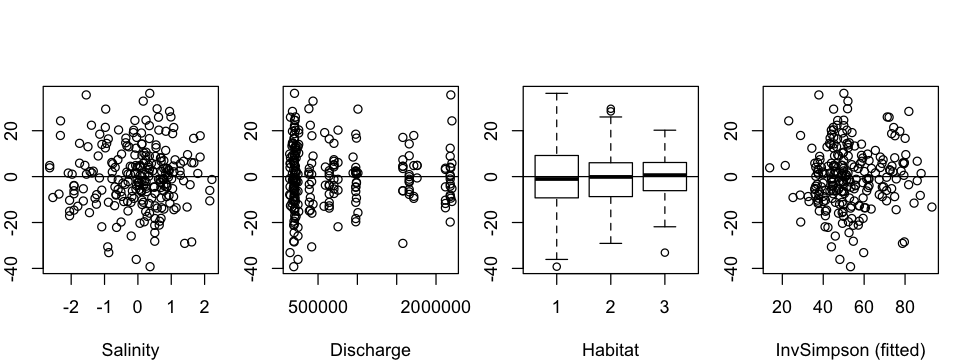

In [98]:
options(repr.plot.width=8, repr.plot.height=3)
par(mfrow = c(1, 4), mar=c(4,2,4,1), cex=0.9)
eE2 <- resid(envM2)
plot(y = eE2, x = pred_resp_i$SALINITY, xlab = "Salinity", ylab = "Residuals")
abline(0,0)
plot(eE2 ~ pred_resp_i$Discharge_Sum.15, xlab = "Discharge", ylab = "Residuals")
abline(0, 0)
plot(eE2 ~ pred_resp_i$HABITAT, xlab = "Habitat", ylab = "Residuals")
abline(0, 0)
plot(eE2 ~ Fit, xlab = "InvSimpson (fitted)", ylab = "Residuals")
abline(0, 0)
par(op)

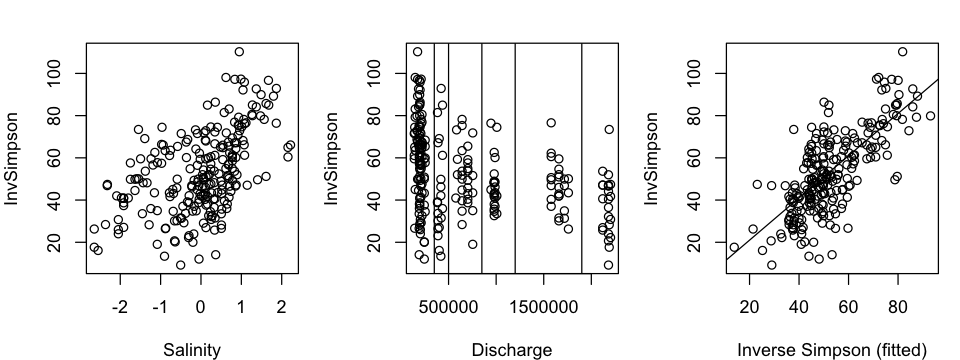

In [123]:
options(repr.plot.width=8, repr.plot.height=3)
par(mfrow = c(1, 3), mar=c(4,4,2,1), cex=0.9)
plot(y = pred_resp_i$InvSimpson, x = pred_resp_i$SALINITY, xlab = "Salinity", ylab = "InvSimpson")
abline(0,0)
plot(pred_resp_i$InvSimpson ~ pred_resp_i$Discharge_Sum.15, xlab = "Discharge", ylab = "InvSimpson")
abline(v=3.5e5)
abline(v=5e5)
abline(v=8.5e5)
abline(v=1.2e6)
abline(v=1.9e6)
plot(pred_resp_i$InvSimpson ~ Fit, xlab = "Inverse Simpson (fitted)", ylab = "InvSimpson")
abline(1, 1)
par(op)

Warning message:
“Can't preserve total widths when varwidth = TRUE.”Warning message:
“Can't preserve total widths when varwidth = TRUE.”Warning message:
“Can't preserve total widths when varwidth = TRUE.”Warning message:
“Can't preserve total widths when varwidth = TRUE.”

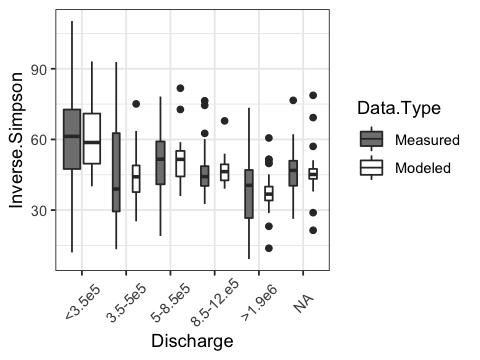

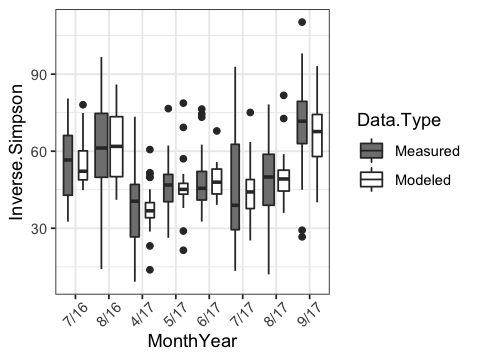

Warning message:
“Removed 6 rows containing missing values (geom_point).”

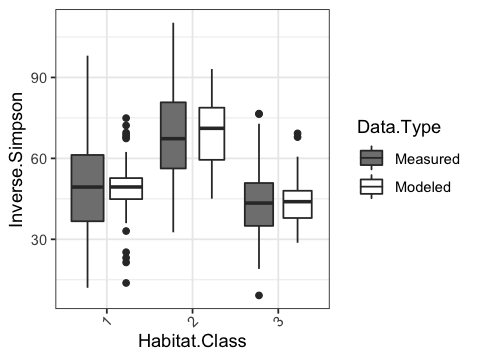

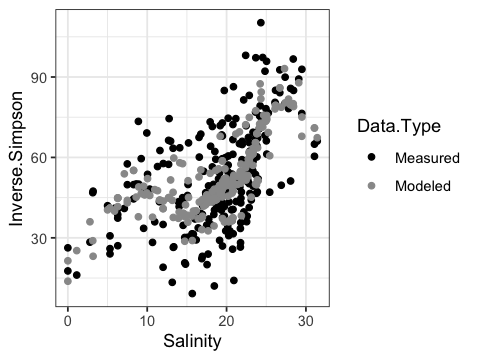

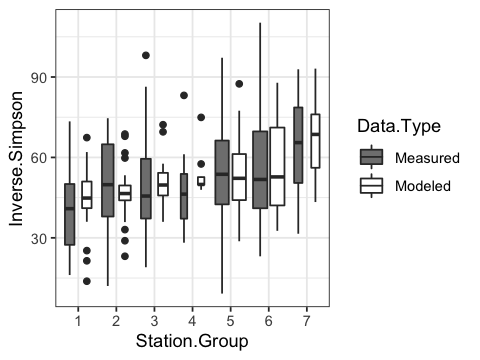

In [217]:
library(ggplot2)
library(lubridate)

selected_predictors1 = c('SALINITY', 'Discharge_Sum.15', 'cruise_id', 'SampleDate')
selected_predictors2 = c('HABITAT', 'StatName')
selected_response = c('InvSimpson')
obs_df = cbind.data.frame(envdata_pre[,selected_predictors1], envdata[,selected_predictors2], 
                          all_alpha[,selected_response])

colnames(obs_df) <- c(selected_predictors1, selected_predictors2, selected_response)

obs_df[,'MonthYear'] <- paste(month(as.POSIXlt(obs_df$SampleDate)), "/", 
                              substring(year(as.POSIXlt(obs_df$SampleDate)), 3), sep="")

obs_df[,'MonthYear'] <- factor(obs_df[,'MonthYear'], 
                               levels=c('7/16', '8/16', '4/17', '5/17', '6/17', '7/17', '8/17', '9/17'))

colnames(obs_df)[colnames(obs_df) == 'Discharge_Sum.15'] = 'Discharge'
colnames(obs_df)[colnames(obs_df) == 'HABITAT'] = 'Habitat.Class'
colnames(obs_df)[colnames(obs_df) == 'SALINITY'] = 'Salinity'
colnames(obs_df)[colnames(obs_df) == 'StatName'] = 'Station.Group'
colnames(obs_df)[colnames(obs_df) == 'cruise_id'] = 'Cruise.ID'
colnames(obs_df)[colnames(obs_df) == 'InvSimpson'] = 'Inverse.Simpson'

obs_df$Cruise.ID <- factor(obs_df$Cruise.ID)

obs_df[,'Data.Type'] = 'Measured'
mod_df = obs_df
mod_df[,'Data.Type'] = 'Modeled'
mod_df[,'Inverse.Simpson'] <- predict(envM2)

obsmod_df = rbind.data.frame(obs_df, mod_df)
obsmod_df$Data.Type <- as.character(obsmod_df$Data.Type)

obsmod_df$DischargeFactor <- NA
obdfD = obsmod_df$Discharge
obsmod_df[ obdfD <= 3.5e5,'DischargeFactor'] = '<3.5e5'
obsmod_df[(obdfD >= 3.5e5) & (obdfD < 5e5), 'DischargeFactor'] = '3.5-5e5'
obsmod_df[(obdfD >= 5e5) & (obdfD < 8.5e5), 'DischargeFactor'] = '5-8.5e5'
obsmod_df[(obdfD >= 8.5e5) & (obdfD < 1.2e6), 'DischargeFactor'] = '8.5-12.e5'
obsmod_df[ obdfD >= 1.9e6,'DischargeFactor'] = '>1.9e6'
obsmod_df$Discharge = factor(obsmod_df$DischargeFactor, 
                             levels = c('<3.5e5', '3.5-5e5', '5-8.5e5', '8.5-12.e5', '>1.9e6'))

options(repr.plot.width=4, repr.plot.height=3)
bp <- ggplot(obsmod_df, aes(x=Discharge, y=Inverse.Simpson, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.5, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))

bp2 <- ggplot(obsmod_df, aes(x=Habitat.Class, y=Inverse.Simpson, fill=Data.Type)) + 
       geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.5, end=1.0) + 
       theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))

bp3 <- ggplot(obsmod_df, aes(x=Salinity, y=Inverse.Simpson, color=Data.Type)) + 
       geom_point() + scale_color_grey(start=0., end=0.6) + theme_bw()

bp4 <- ggplot(obsmod_df, aes(x=Station.Group, y=Inverse.Simpson, fill=Data.Type)) + 
       geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.5, end=1.0) + theme_bw()

bp1 <- ggplot(obsmod_df, aes(x=MonthYear, y=Inverse.Simpson, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.5, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))

bp
bp1
bp2
bp3
bp4



In [224]:
sum(c(dim(combn(1:7, 7))[2],
dim(combn(1:7, 6))[2],
dim(combn(1:7, 5))[2],
dim(combn(1:7, 4))[2],
dim(combn(1:7, 3))[2],
dim(combn(1:7, 2))[2],
dim(combn(1:7, 1))[2]))

sum(c(dim(combn(1:5, 5))[2],
dim(combn(1:5, 4))[2],
dim(combn(1:5, 3))[2],
dim(combn(1:5, 2))[2],
dim(combn(1:5, 1))[2]))

127*31*10000

[1] 127

[1] 31

[1] 39370000

In [148]:

upper_model = lm(FaithsPD ~ FallPeak+LinearTime+PO4F+Discharge_Sum.15+DO+CHLA+TP+WTEMP+Discharge_Susquehanna.15+SALINITY+NO2F+TN, data=pred_resp_f)
lower_model = lm(FaithsPD ~ 1, data=pred_resp_f)
n = length(resid(lower_model))

fbstep_faith = stepAIC(lower_model, scope=formula(upper_model), scale = 0, direction = 'both', k=log(n), trace=1)
length(colnames(fbstep_faith$model))
extractAIC(fbstep_faith)
colnames(fbstep_faith$model)


Start:  AIC=3269.9
FaithsPD ~ 1

                           Df Sum of Sq       RSS    AIC
+ FallPeak                  1 130053946 109958812 3091.1
+ PO4F                      1 123837501 116175257 3104.1
+ Discharge_Sum.15          1 122357353 117655404 3107.1
+ Discharge_Susquehanna.15  1 117400183 122612575 3116.9
+ DO                        1  95980607 144032151 3154.9
+ WTEMP                     1  88415512 151597245 3166.9
+ TP                        1  83030040 156982718 3175.2
+ CHLA                      1  60064379 179948379 3207.4
+ NO2F                      1  39025386 200987371 3233.5
+ SALINITY                  1  15867618 224145140 3259.2
<none>                                  240012758 3269.9
+ TN                        1   2508596 237504161 3272.9
+ LinearTime                1   2072741 237940016 3273.3

Step:  AIC=3091.15
FaithsPD ~ FallPeak

                           Df Sum of Sq       RSS    AIC
+ DO                        1  33597212  76361600 3010.6
+ CHLA        

[1] 4

[1]    4.000 2992.722

[1] "FaithsPD" "FallPeak" "DO"       "CHLA"

In [160]:
fM1 <- lm(FaithsPD ~ FallPeak + DO + CHLA, data = pred_resp_f)
fM2 <- lm(FaithsPD ~ FallPeak + DO + CHLA + SALINITY, data = pred_resp_f)
fM3 <- lm(FaithsPD ~ FallPeak + DO + CHLA + LinearTime, data = pred_resp_f)
anova(fM1, fM2, fM3)
postResample(pred=predict(fM1), obs=pred_resp_f$FaithsPD)
postResample(pred=predict(fM2), obs=pred_resp_f$FaithsPD)
postResample(pred=predict(fM3), obs=pred_resp_f$FaithsPD)
anova(fM3)
summary(fM3)
vif(fM3)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
232,73365217,NA,NA,NA,NA
231,72413114,1,952103.5,3.037239,0.08270494
231,71827573,0,585540.6,NA,NA


RMSE    Rsquared         MAE 
557.5567808   0.6943278 439.8686212

RMSE    Rsquared         MAE 
553.9270954   0.6982947 435.0903509

RMSE    Rsquared         MAE 
551.6829913   0.7007344 434.6429806

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
FallPeak,1,130053946,130053945.6,418.258061,9.486517e-54
DO,1,33597212,33597211.6,108.049814,5.197971e-21
CHLA,1,2996383,2996383.4,9.636474,2.145668e-03
LinearTime,1,1537644,1537644.0,4.945117,2.713235e-02
Residuals,231,71827573,310941.9,NA,NA



Call:
lm(formula = FaithsPD ~ FallPeak + DO + CHLA + LinearTime, data = pred_resp_f)

Residuals:
     Min       1Q   Median       3Q      Max 
-1623.30  -359.52   -33.64   349.41  1425.19 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2468.39     115.02  21.460  < 2e-16 ***
FallPeak      900.08      60.03  14.995  < 2e-16 ***
DO           -282.88      63.78  -4.436 1.42e-05 ***
CHLA          185.99      59.05   3.150  0.00185 ** 
LinearTime    192.06      86.37   2.224  0.02713 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 557.6 on 231 degrees of freedom
Multiple R-squared:  0.7007,	Adjusted R-squared:  0.6956 
F-statistic: 135.2 on 4 and 231 DF,  p-value: < 2.2e-16


FallPeak         DO       CHLA LinearTime 
  1.223482   3.074015   2.635147   1.095806

In [164]:
vf4 <- varIdent(form =~ StatName)
fA2 <- gam(FaithsPD ~ s(LinearTime, bs='cs') + s(DO, bs='cs') + 
                      s(FallPeak, bs='cs') + s(CHLA, bs='cs'), data = pred_resp_f)

fAM2 <- gamm(FaithsPD ~ s(LinearTime, bs='cs') + s(DO, bs='cs') +
                        s(FallPeak, bs='cs') + s(CHLA, bs='cs'),
                        data = pred_resp_f, weights = vf4)

postResample(pred=predict(fA2), obs=pred_resp_f$FaithsPD)
postResample(pred=predict(fAM2$gam), obs=pred_resp_f$FaithsPD)

summary(fA2)
summary(fAM2$gam)
anova(fA2)
coef(fA2)

RMSE    Rsquared         MAE 
533.5254250   0.7203684 413.3601896

RMSE    Rsquared         MAE 
544.6565816   0.7084085 425.2525581


Family: gaussian 
Link function: identity 

Formula:
FaithsPD ~ s(LinearTime, bs = "cs") + s(DO, bs = "cs") + s(FallPeak, 
    bs = "cs") + s(CHLA, bs = "cs")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2976.82      35.57   83.69   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df     F  p-value    
s(LinearTime) 1.7179      9 0.479   0.0673 .  
s(DO)         1.1079      9 2.470 1.74e-08 ***
s(FallPeak)   6.3968      9 4.418 8.24e-08 ***
s(CHLA)       0.8095      9 1.337 2.40e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.708   Deviance explained =   72%
GCV = 3.1325e+05  Scale est. = 2.9861e+05  n = 236


Family: gaussian 
Link function: identity 

Formula:
FaithsPD ~ s(LinearTime, bs = "cs") + s(DO, bs = "cs") + s(FallPeak, 
    bs = "cs") + s(CHLA, bs = "cs")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2976.82      36.03   82.62   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                edf Ref.df     F  p-value    
s(LinearTime) 1.737      9 0.940 0.005849 ** 
s(DO)         1.716      9 2.572  4.2e-07 ***
s(FallPeak)   1.986      9 5.120  < 2e-16 ***
s(CHLA)       1.091      9 1.085 0.000956 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =    0.7   
  Scale est. = 3.0509e+05  n = 236


Family: gaussian 
Link function: identity 

Formula:
FaithsPD ~ s(LinearTime, bs = "cs") + s(DO, bs = "cs") + s(FallPeak, 
    bs = "cs") + s(CHLA, bs = "cs")

Approximate significance of smooth terms:
                 edf Ref.df     F  p-value
s(LinearTime) 1.7179 9.0000 0.479   0.0673
s(DO)         1.1079 9.0000 2.470 1.74e-08
s(FallPeak)   6.3968 9.0000 4.418 8.24e-08
s(CHLA)       0.8095 9.0000 1.337 2.40e-05

(Intercept) s(LinearTime).1 s(LinearTime).2 s(LinearTime).3 s(LinearTime).4 
     2976.81909       -40.33461       -96.35189      -217.37563      -167.40694 
s(LinearTime).5 s(LinearTime).6 s(LinearTime).7 s(LinearTime).8 s(LinearTime).9 
     -103.80914        -3.98952        88.19002       185.42711       270.70539 
        s(DO).1         s(DO).2         s(DO).3         s(DO).4         s(DO).5 
      211.25749        96.28081       -21.88189      -118.88466      -220.63846 
        s(DO).6         s(DO).7         s(DO).8         s(DO).9   s(FallPeak).1 
     -330.45927      -306.17800      -533.04108      -607.09713      -387.10404 
  s(FallPeak).2   s(FallPeak).3   s(FallPeak).4   s(FallPeak).5   s(FallPeak).6 
     -295.07313       271.49554       303.10955       609.36864       698.36476 
  s(FallPeak).7   s(FallPeak).8   s(FallPeak).9       s(CHLA).1       s(CHLA).2 
      720.94503       589.54418       775.95294       -61.16683       -68.30348 
      s(CHLA).3       s(CHLA).4       s(CHLA).5       s(CHLA).6       s(CHLA).7 
       24.43215        11.45125       101.98342       234.42155       186.17357 
      s(CHLA).8       s(CHLA).9 
      435.81749       432.56290

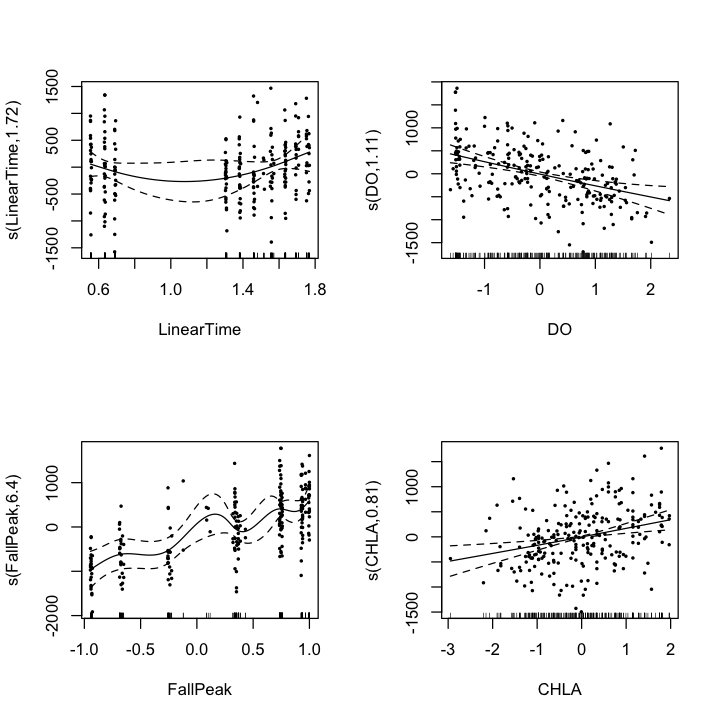

In [181]:
options(repr.plot.width=6, repr.plot.height=6)
op <- par(mfrow = c(2, 2))
plot(fA2,residuals=TRUE,pch=19,cex=.3,scale=0)


	Shapiro-Wilk normality test

data:  fE2
W = 0.99489, p-value = 0.6163


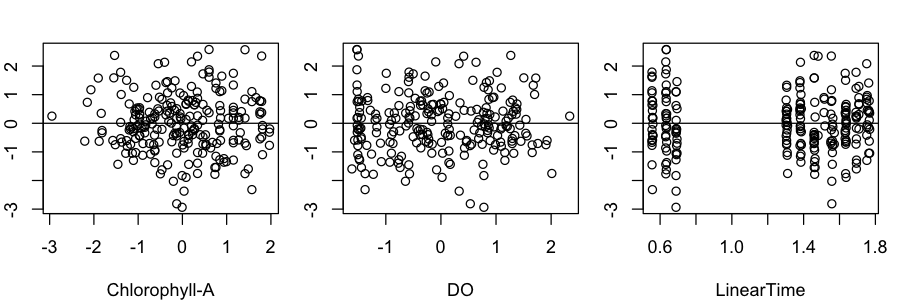

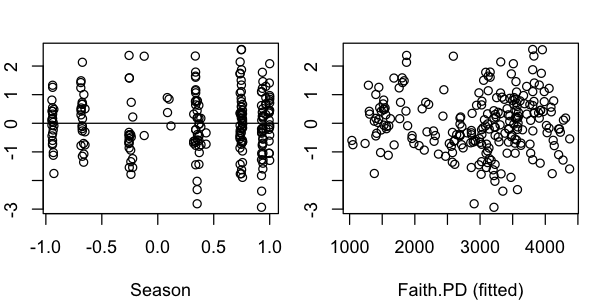

In [180]:

options(repr.plot.width=7.5, repr.plot.height=2.5)
par(mfrow = c(1, 3), mar=c(4,2,2,1), cex=0.9)
fE2 <- scale(resid(fM3))
Fit.fA2 <- fitted(fM3)
shapiro.test(fE2)
plot(y = fE2, x = pred_resp_f[,'CHLA'], xlab = "Chlorophyll-A", ylab = "Residuals")
abline(0,0)
plot(fE2 ~ pred_resp_f[,'DO'], xlab = "DO", ylab = "Residuals")
abline(0, 0)
plot(fE2 ~ pred_resp_f[,'LinearTime'], xlab = "LinearTime", ylab = "Residuals")
abline(0, 0)
par(op)

options(repr.plot.width=5, repr.plot.height=2.5)
par(mfrow = c(1, 2), mar=c(4,2,2,1), cex=0.9)
plot(fE2 ~ pred_resp_f[,'FallPeak'], xlab = "Season", ylab = "Residuals")
abline(0, 0)
plot(fE2 ~ Fit.fA2, xlab = "Faith.PD (fitted)", ylab = "Residuals")
abline(1, 1)
par(op)




Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 31 iterations.
The RMS GCV score gradient at convergence was 2.956789 .
The Hessian was positive definite.
Model rank =  37 / 37 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                 k'   edf k-index p-value   
s(LinearTime) 9.000 1.718    0.94   0.155   
s(DO)         9.000 1.108    0.91   0.055 . 
s(FallPeak)   9.000 6.397    1.00   0.470   
s(CHLA)       9.000 0.809    0.83   0.005 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


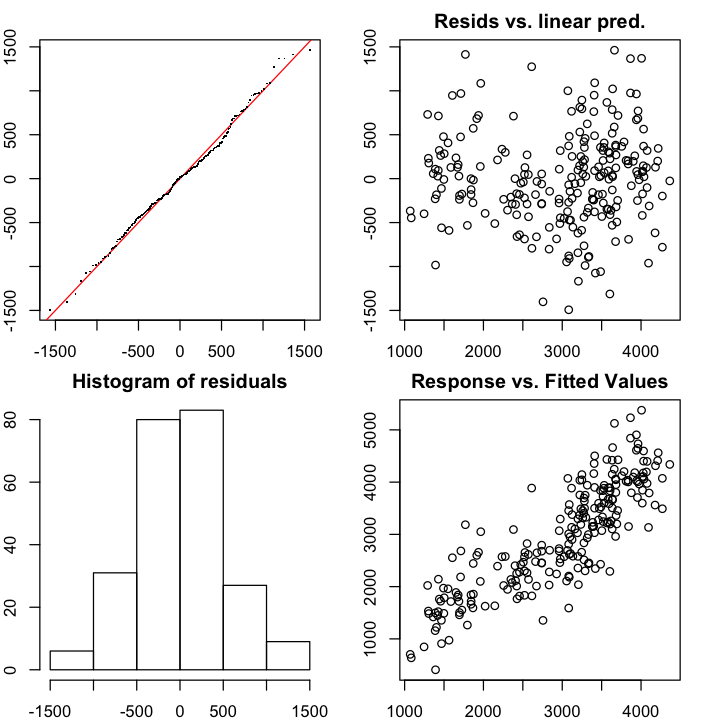

In [177]:
options(repr.plot.width=6, repr.plot.height=6)
par(mar = c(2, 2, 2, 2))
gam.check(fA2)

In [213]:
library(lubridate)
selected_predictors1 = c('cruise_id', 'DO', 'FallPeak', 'SampleDate', 'CHLA', 'LinearTime')
selected_predictors2 = c('StatName')
selected_response = c('FaithsPD')
obs_df = cbind.data.frame(envdata_pre[,selected_predictors1], envdata[,selected_predictors2], 
                          all_alpha[,selected_response])
colnames(obs_df) <- c(selected_predictors1, selected_predictors2, selected_response)
obs_df[,'MonthYear'] <- paste(month(as.POSIXlt(obs_df$SampleDate)), "/", substring(year(as.POSIXlt(obs_df$SampleDate)), 3), sep="")
obs_df[,'MonthYear'] <- factor(obs_df[,'MonthYear'], 
                               levels=c('7/16', '8/16', '4/17', '5/17', '6/17', '7/17', '8/17', '9/17'))
obs_df[,'Month'] <- factor(month(as.POSIXlt(obs_df$SampleDate)))
colnames(obs_df)[colnames(obs_df) == 'cruise_id'] = 'Cruise.ID'
obs_df$Cruise.ID <- factor(obs_df$Cruise.ID)
colnames(obs_df)[colnames(obs_df) == 'MonthYear'] = 'Month.Year'
colnames(obs_df)[colnames(obs_df) == 'DO'] = 'Dissolved.Oxygen'
colnames(obs_df)[colnames(obs_df) == 'CHLA'] = 'Chlorophyll.A'
colnames(obs_df)[colnames(obs_df) == 'FallPeak'] = 'Seasonality.Fxn'
colnames(obs_df)[colnames(obs_df) == 'StatName'] = 'Station.Group'

obs_df[,'Data.Type'] = 'Measured'
mod_df = obs_df
mod_df[,'Data.Type'] = 'Modeled'
fM3 <- lm(FaithsPD ~ Seasonality.Fxn + Dissolved.Oxygen + Chlorophyll.A + LinearTime, data = obs_df)
summary(fM3)


Call:
lm(formula = FaithsPD ~ Seasonality.Fxn + Dissolved.Oxygen + 
    Chlorophyll.A + LinearTime, data = obs_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.4859  -2.2363  -0.1135   2.3231   9.5978 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      42.20552    0.84471  49.964  < 2e-16 ***
Seasonality.Fxn   6.41770    0.42063  15.257  < 2e-16 ***
Dissolved.Oxygen -0.91202    0.11779  -7.743 3.28e-13 ***
Chlorophyll.A    -0.06717    0.08225  -0.817   0.4150    
LinearTime        1.39561    0.60396   2.311   0.0218 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.835 on 225 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.7117,	Adjusted R-squared:  0.7066 
F-statistic: 138.9 on 4 and 225 DF,  p-value: < 2.2e-16


[1] "Cruise.ID"        "Dissolved.Oxygen" "Seasonality.Fxn"  "SampleDate"      
 [5] "Chlorophyll.A"    "LinearTime"       "Station.Group"    "FaithsPD"        
 [9] "Month.Year"       "Month"            "Data.Type"

[1] "Cruise.ID"        "Dissolved.Oxygen" "Seasonality.Fxn"  "SampleDate"      
 [5] "Chlorophyll.A"    "LinearTime"       "Station.Group"    "FaithsPD"        
 [9] "Month.Year"       "Month"            "Data.Type"


    (-0.5, 0) (-0.75, -0.5)      (0, 0.5)   (0.5, 0.85)       < -0.75 
           48            50            96           104            48 
       > 0.85 
          126 

Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”

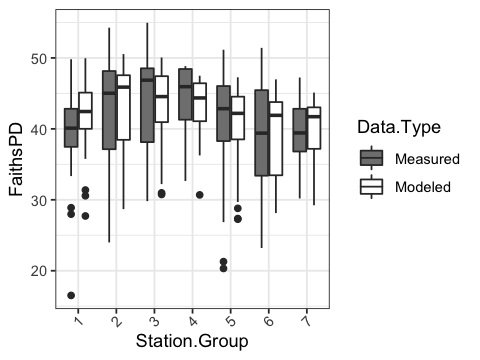

Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”

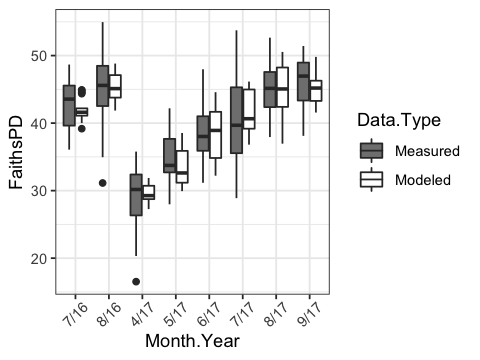

Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”

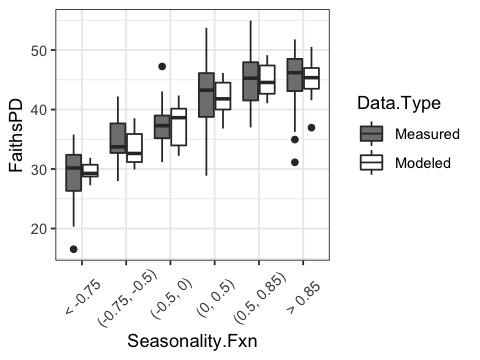

Warning message:
“Removed 9 rows containing missing values (geom_point).”

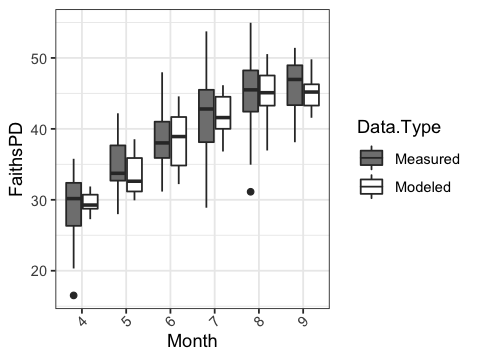

Warning message:
“Removed 9 rows containing missing values (geom_point).”

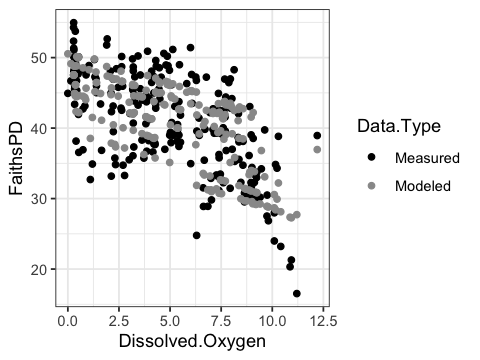

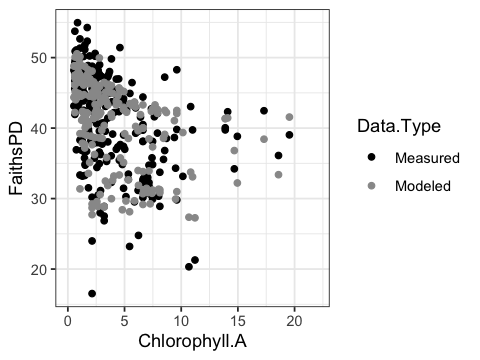

In [216]:
mod_df[,'FaithsPD'] <- predict(fM3)[rownames(obs_df)]
colnames(mod_df)
colnames(obs_df)
obsmod_df = rbind.data.frame(obs_df, mod_df)
obsmod_df$Data.Type <- as.character(obsmod_df$Data.Type)

obsmod_df$ADLF <- NA
obdfADL = obsmod_df$Seasonality.Fxn
obsmod_df[ (obdfADL < -0.75), 'ADLF'] <- '< -0.75'
obsmod_df[ (obdfADL > -0.75) & (obdfADL < -0.5), 'ADLF'] <- '(-0.75, -0.5)'
obsmod_df[ (obdfADL > -0.5) & (obdfADL < 0.0), 'ADLF'] <- '(-0.5, 0)'
obsmod_df[  (obdfADL > 0.0) & (obdfADL < 0.5), 'ADLF'] <- '(0, 0.5)'
obsmod_df[ (obdfADL > 0.5) & (obdfADL < 0.85), 'ADLF'] <- '(0.5, 0.85)'
obsmod_df[ (obdfADL > 0.85), 'ADLF'] <- '> 0.85'

table(obsmod_df$ADLF)
adlf_levels = c('< -0.75', '(-0.75, -0.5)', '(-0.5, 0)', '(0, 0.5)', '(0.5, 0.85)', '> 0.85')
obsmod_df$Seasonality.Fxn = factor(obsmod_df$ADLF, levels = adlf_levels)


options(repr.plot.width=4, repr.plot.height=3)
bp <- ggplot(obsmod_df, aes(x=Station.Group, y=FaithsPD, fill=Data.Type)) + 
      geom_boxplot() + scale_fill_grey(start=0.5, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))

bp2 <- ggplot(obsmod_df, aes(x=Seasonality.Fxn, y=FaithsPD, fill=Data.Type)) + 
       geom_boxplot() + scale_fill_grey(start=0.5, end=1.0) + 
       theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))

bp_B <- ggplot(obsmod_df, aes(x=Month.Year, y=FaithsPD, fill=Data.Type)) + 
      geom_boxplot() + scale_fill_grey(start=0.5, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))

bp2_B <- ggplot(obsmod_df, aes(x=Month, y=FaithsPD, fill=Data.Type)) + 
       geom_boxplot() + scale_fill_grey(start=0.5, end=1.0) + 
       theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))

bp3 <- ggplot(obsmod_df, aes(x=Dissolved.Oxygen, y=FaithsPD, color=Data.Type)) + 
       geom_point() + scale_color_grey(start=0., end=0.6) + theme_bw()

bp4 <- ggplot(obsmod_df, aes(x=Chlorophyll.A, y=FaithsPD, color=Data.Type)) + 
       geom_point() + scale_color_grey(start=0., end=0.6) + theme_bw() + coord_cartesian(xlim=c(0, 22))
bp
bp_B
bp2
bp2_B
bp3
bp4



In [ ]:
weirdness = (tdata$SALINITY > 12) & (tdata$SALINITY < 16) & (tdata$faith_pd > 30 ) & (tdata$faith_pd < 40 )
tdata[weirdness, c("StationName", 'Month_Year', 'Depth', 'DO', 'SALINITY', 'faith_pd')]


obsmod_df_obs = obsmod_df[obsmod_df$Data.Type == 'Measured',]
aggregate(obsmod_df_obs$Faith.PD, by=list(obsmod_df_obs$Julian.Day), FUN=mean)

In [ ]:

library(mgcv)
mixing_f = "/Volumes/KeithSSD/CB_V4/otu_data/mixing_data/2016_transect_mixing_data_products.txt"
mix_df = read.delim(mixing_f, row.names=2)
mix_df$X <- NULL
select_cols = c('faith_pd', 'WTEMP', 'Latitude', 'Depth', 'StatName', 'DO', 'PH',
                'SALINITY', 'anti_day_length', 'AC_PrinComp2', 'julian_day')

subfull = fulldata[rownames(mix_df), select_cols]
mixing_plus = cbind.data.frame(subfull, mix_df[,c(6:ncol(mix_df))])

# standardize the numeric columns
predictors_ns <- mixing_plus %>% mutate_if(is.numeric, list(~ as.numeric(scale(.))) )

corr <- data.frame(lapply(predictors_ns[,c('faith_pd', 'Latitude', 'DO','south_lim', 'WTEMP')], as.double))
# Plot the graph
#options(repr.plot.width=7, repr.plot.height=7)
#ggcorr(corr, method = c("pairwise", "spearman"), nbreaks = 6,
#       hjust = 0.92, size=4, label = TRUE, label_size = 2, color = "grey25")

pred_cols = c('WTEMP', 'Latitude', 'Depth', 'StatName', 'DO', 'PH', 'SALINITY', 
              'anti_day_length', 'AC_PrinComp2', 'julian_day', 'sum_horiz_dist', 'sum_vert_dist',
              'sum_downwelling', 'sum_upwelling', 'north_lim', 'south_lim', 'east_lim', 'west_lim',
              'up_lim', 'down_lim')
sum(pred_cols %in% colnames(mixing_plus))
length(pred_cols)
stepper = gam(faith_pd ~ s(Latitude, br='cs') + s(Depth, br='cs') + s(DO, br='cs') + s(PH, br='cs') + s(SALINITY, br='cs') + s(anti_day_length, br='cs') + s(AC_PrinComp2, br='cs') + s(julian_day, br='cs') + s(sum_horiz_dist, br='cs') + s(sum_vert_dist, br='cs') + s(sum_downwelling, br='cs') + s(sum_upwelling, br='cs') + s(north_lim, br='cs') + s(south_lim, br='cs') + s(east_lim, br='cs') + s(west_lim, br='cs') + s(up_lim, br='cs') + s(down_lim, br='cs'), data=mixing_plus)
#stepper
#fbstep_enspie = stepAIC(lower_model, scope=formula(upper_model), scale = 0, direction = 'forward', k=log(n), trace=0)
#length(colnames(fbstep_enspie$model))


fM2 <- gam(faith_pd ~ s(DO, bs = "cs") + s(south_lim, bs='cs') + s(WTEMP, bs='cs'), data = mixing_plus)


#anova(fM2)
#anova(fM2)
#summary(fM2)
#shapiro.test(resid(fM2))


In [ ]:
paste(colnames(mixing_plus), collapse="','")

In [ ]:
lmc <- lmeControl(niterEM = 5200, msMaxIter = 5200)

Mlm <- lm(Faiths.PD ~ Month*Year + Depth, data=faiths_df)
Mlme1 <- lme(Faiths.PD ~ 1 + Month + Depth, random = ~ 1 | Year, data=faiths_df, method="ML")
Mlme2 <- lme(Faiths.PD ~ 1 + Year + Depth, random = ~ 1 | Month, data=faiths_df, method="ML")

AIC(Mlme1, Mlme2, Mlm)
anova(Mlme1, Mlme2, Mlm)
summary(Mlme1)

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
E2 <- resid(Mlme1, type = "normalized")
F2 <- fitted(Mlme1)
op <- par(mfrow = c(2, 2), mar = c(4, 4, 3, 2))
MyYlab <- "Residuals"
plot(x = F2, y = E2, xlab = "Fitted values", ylab = MyYlab)
boxplot(E2 ~ faiths_df$Year, main = "Year", ylab = MyYlab)
plot(E2 ~ faiths_df$Depth, main = "Depth", ylab = MyYlab)
plot(x = month_year2, y = E2, ylab = MyYlab, main = "Month Year")
par(op)

In [ ]:



# cross validating smoothers is given by: 
# AM2 <- gam(ABUND  ̃ s(L.AREA, bs = "cs") + s(L.DIST, bs = "cs") + s(L.LDIST,bs = "cs") 
#                  + s(YR.ISOL, bs = "cs") + s(ALT, bs = "cs") + fGRAZE, data = Loyn)
# "edf" column in summary will show the relative amount of smoothing, if = 0, term is linear? 
# plots residuals against fitted values
# > plot(M1, which = c(1), col = 1, add.smooth = FALSE, caption = "")
# plot the residuals against each individual explanatory variable
# > plot(Squid$fMONTH, resid(M1), xlab = "Month", ylab = "Residuals")
# > plot(Squid$DML, resid(M1), xlab = "DML", ylab = "Residuals")
## This plots the residuals versus the two predictors in question, there is a facet for each factor level in month
# > E <- resid(M.lm)
# > coplot(E ∼ DML | fMONTH, data = Squid)


# (generalized least squares is a flavor of linear model with homogeneity corrections) 
# when the residuals deviate systematically with a variable, you can use a fixed variance structure:
# M.gls1 <- gls(Testisweight ∼ DML * fMONTH, weights = varFixed(∼DML), data = Squid)
# compare with: 
# M.lm <- gls(Testisweight ∼ DML * fMONTH, data=Squid)
# AIC(M.lm, M.gls1)
# if there is a variance structure that changes per a factor explanatory variable, we use:
# vf2 <- varIdent(form= ∼ 1 | fMONTH)
# as an alternative for the previous two, we can try:
# vf4 <- varPower(form =∼ DML | fMONTH) OR varExp(form =∼ DML | fMONTH) OR varConstPower(form =∼ DML | fMONTH)
# it is not clear if we can combine terms in varFixed or varIdent, but we can combine them seperately, e.g.
# vf8 <- varComb(varIdent(form =∼ 1 | fMONTH) , varExp(form =∼ DML) )
# varPower cannot be used if the covariate is ever equal to 0
## To confirm your choice, plot the error distribution versus predictors 
#E2 <- resid(M.gls4, type = "normalized") > coplot(E2 ∼ DML | fMONTH, data = Squid,
#ylab = "Normalised residuals")

#summary(continuous)
# plot a variable
#library(ggplot2)
#ggplot(continuous, aes(x = hours.per.week)) + geom_density(alpha = .2, fill = "#FF6666")
#ggplot(continuous, aes(x = educational.num)) + geom_density(alpha = .2, fill = "#32CD32")
#library(dplyr)

In [ ]:
set.seed(14)
create_train_test <- function(data, size = 0.8, train = TRUE) {
    n_row = nrow(data)
    total_row = size * n_row
    train_sample <- 1: total_row
    if (train == TRUE) {
        return (data[train_sample, ])
    } else {
        return (data[-train_sample, ])
    }
}
full_data = cbind(scale(response), predictors_ns)
colnames(full_data)[1] <- phenotype
row.names(full_data) <- row.names(mdata)
data_train <- create_train_test(full_data, 0.6, train = TRUE)
data_test <- create_train_test(full_data, 0.6, train = FALSE)
dim(data_train)
dim(data_test)
row.names(data_train)[1:5]

In [ ]:
head(data_train)

In [ ]:
library(scorer)
library(MASS)
library(caret)
library(leaps)
simple_model <- lm(faith_pd ~., data = data_train)
step_model <- stepAIC(simple_model, direction = "both", trace=FALSE)
ls(step_model)
summary(step_model)


In [ ]:
opt_model = lm(formula = faith_pd ~ Longitude + TrimCount + Year + julian_day + day_length + WTEMP + DO + PH + Depth_Percentage + Discharge_Susquehanna_14, data = data_train)
pred.w.clim <- predict(opt_model, data_test, interval = "confidence")
print(r2_score(data_test[,'faith_pd'], pred.w.clim[,'fit']))
pred.w.clim <- predict(simple_model, data_test, interval = "confidence")
print(r2_score(data_test[,'faith_pd'], pred.w.clim[,'fit']))



train.control <- trainControl(method="cv", number = 10)
step_model <- train(faith_pd ~., data = full_data, method = "leapSeq", trControl=train.control,
                    tuneGrid=data.frame(nvmax=1:15))

step_model$results
summary(step_model$finalModel)


In [ ]:
qqPlot(simple_model, simulate=T)
outlierTest(simple_model, labels=row.names(data_train))

In [ ]:
library(car)
pt_obj = powerTransform(continuous)
coef(p1, round=TRUE)
summary(m1 <- lm(bcPower(cycles, p1$roundlam) ~ len + amp + load, Wool))

#summary(p1 <- powerTransform(cycles ~ len + amp + load, Wool))
#ggplot(continuous, aes(x = hours.per.week)) + geom_density(alpha = .2, fill = "#FF6666")
#ggplot(data_adult_rescale, aes(x = educational.num)) + geom_density(alpha = .2, fill = "#32CD32")

In [ ]:
library(SoDA)
library(adespatial)
subm_geop <- mdata[,c("Longitude", "Latitude", "StationName")]
aggSub <- aggregate(.~ StationName, subm_geop, FUN=mean)

cart_coords = geoXY(latitude=aggSub$Latitude, longitude=aggSub$Longitude, unit=1000)
row.names(cart_coords) <- aggSub$StationName
stat_dists <- matrix(nrow=20, ncol=20)
for(i in 1:dim(stat_dists)[1]){
    for(j in 1:dim(stat_dists)[2]){
        stat_dists[i, j] <- geoDist(aggSub$Latitude[i], aggSub$Longitude[i], aggSub$Latitude[j], aggSub$Longitude[j])
    }
}
colnames(stat_dists) <- aggSub$StationName; row.names(stat_dists) <- aggSub$StationName;
cb.dbmem <- as.data.frame(dbmem(cart_coords, thresh = 45.0 ,silent = TRUE))
row.names(cb.dbmem) <- aggSub$StationName;
dim(mdata)
mdata[, colnames(cb.dbmem)] <- NA
for(cn in colnames(cb.dbmem)){
    for(stat_name in row.names(cb.dbmem)){
        mdata[mdata$StationName == stat_name , cn] <- cb.dbmem[stat_name, cn]
    }
}
head(mdata[c(66,77,99,111,155,200,225,250,300), colnames(cb.dbmem)])